In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Parameters

In [143]:
vz = 184 # m/s
vzσ = 16 # m/s

zσ = 1e-2 # m

pulse_width_absorption = 1e-3 # s

n_trajectories = 500_000

# Point Source

In [129]:
v_origin = np.random.randn(n_trajectories)*vzσ + vz

In [130]:
df = pd.DataFrame()
for distance in np.arange(0.5, 7, 0.5):
    t = distance / v_origin
    df = pd.concat([df, pd.DataFrame({'time': t, 'distance': distance})])

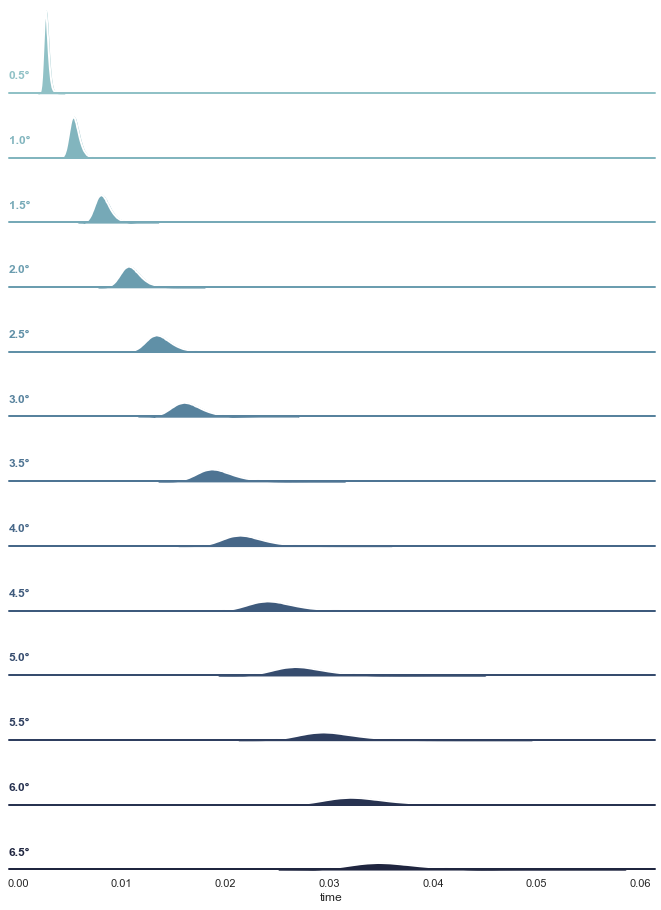

In [131]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(np.unique(df.distance).size, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="distance", hue="distance", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "time",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "time", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f"{label}°", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);

In [132]:
distances = np.arange(0.5, 7, 0.5)

df = pd.DataFrame(columns = pd.MultiIndex.from_product([distances, ['time', 'velocity']]))

for distance in distances:
    t = distance / v_origin
    df[distance] = pd.DataFrame({'time': t, 'velocity': v_origin})

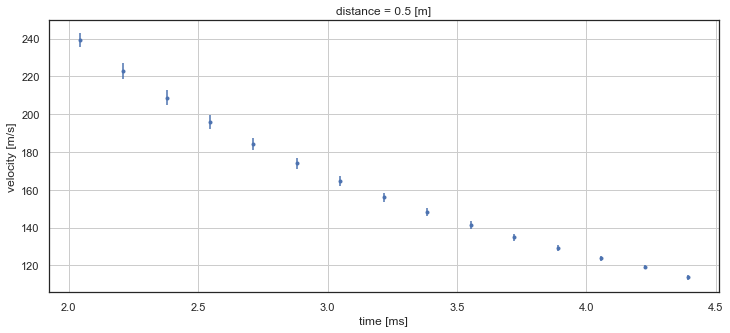

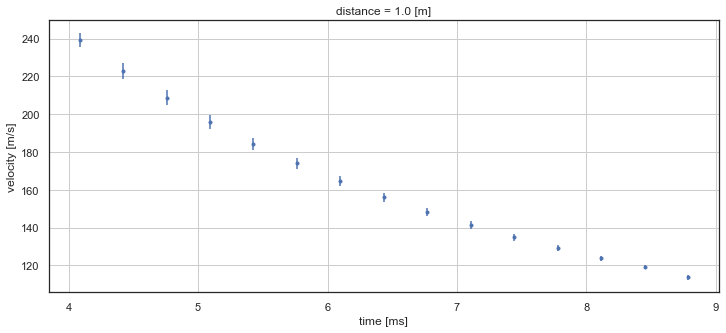

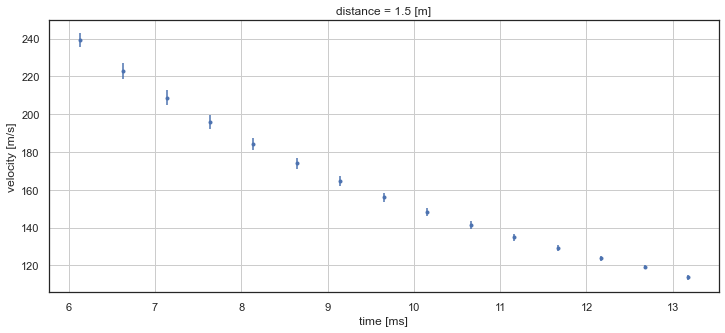

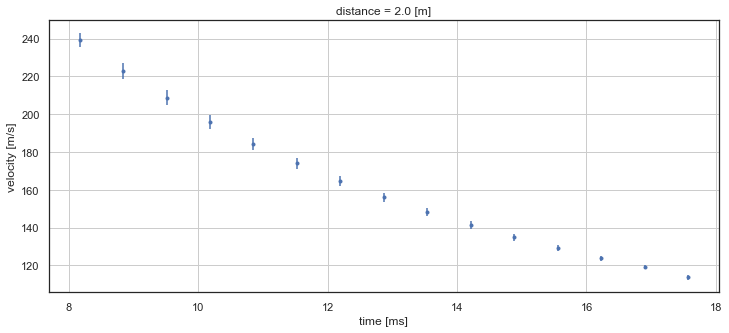

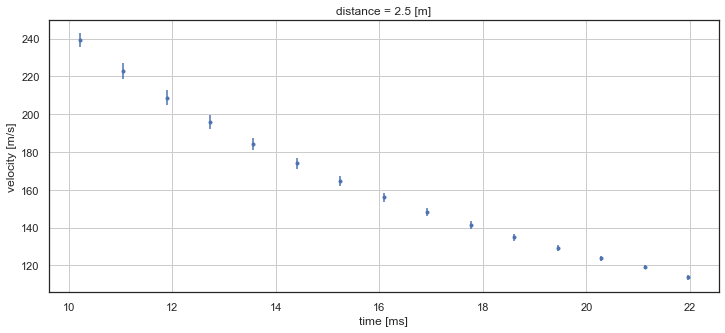

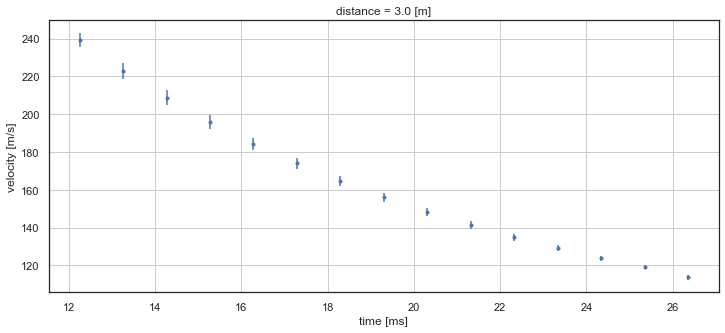

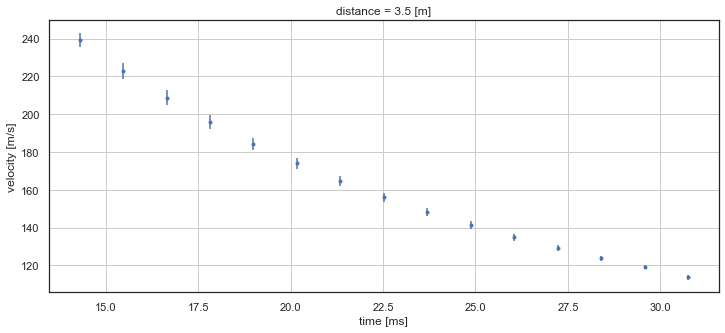

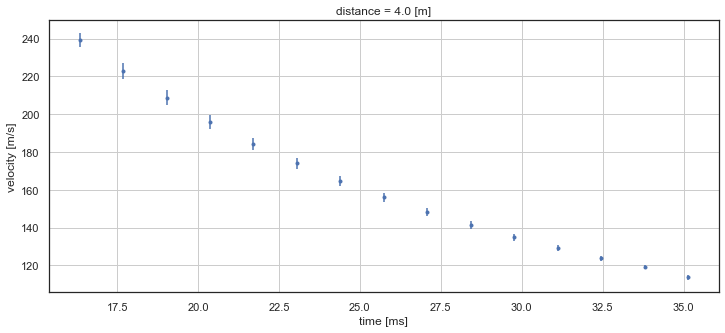

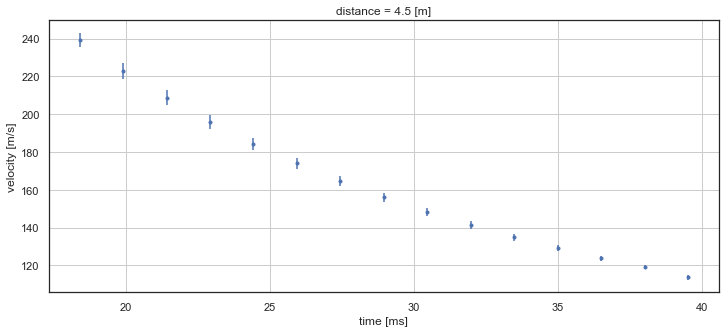

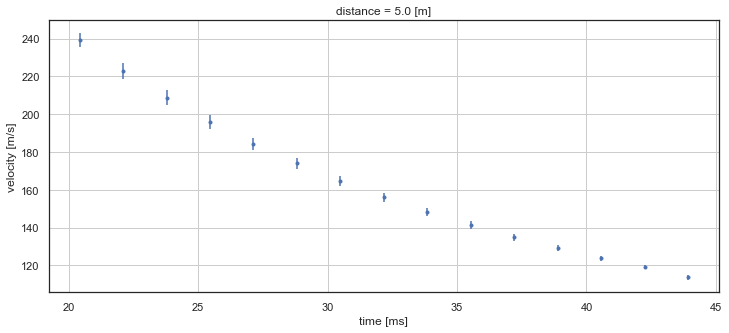

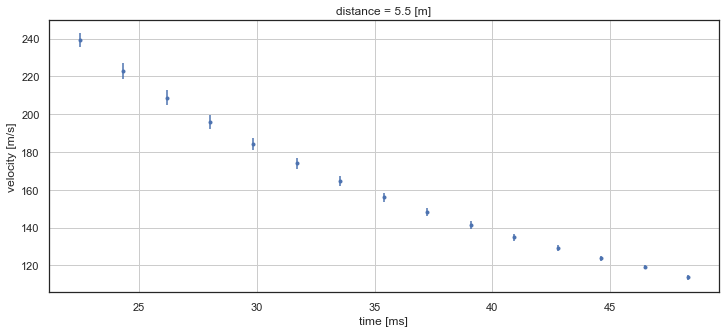

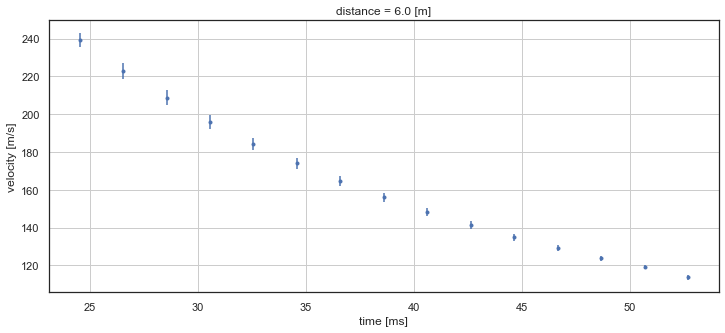

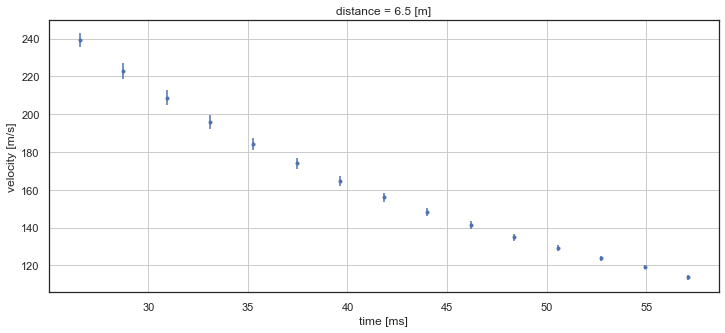

In [133]:
for distance in distances:
    dat = df[distance]
    m, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.mean, bins = 15)
    )
    std, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.std, bins = 15)
    )
    bins = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    bins *= 1e3
    fig, ax = plt.subplots(figsize = (12,5))
    ax.errorbar(bins, m, yerr = std, fmt = '.')
    ax.set_xlabel("time [ms]")
    ax.set_ylabel("velocity [m/s]")
    ax.set_title(f"distance = {distance:>3.1f} [m]")
    ax.grid(True)

# Gaussian Source Random Velocities Spread out source

In [144]:
v_origin = np.random.randn(n_trajectories)*vzσ + vz
z_origin = np.random.randn(n_trajectories)*zσ

In [145]:
distances = np.arange(1, 7.1, 1)

df = pd.DataFrame(columns = pd.MultiIndex.from_product([distances, ['time', 'velocity']]))

for distance in distances:
    t = (distance + z_origin) / v_origin
    df[distance] = pd.DataFrame({'time': t, 'velocity': v_origin})

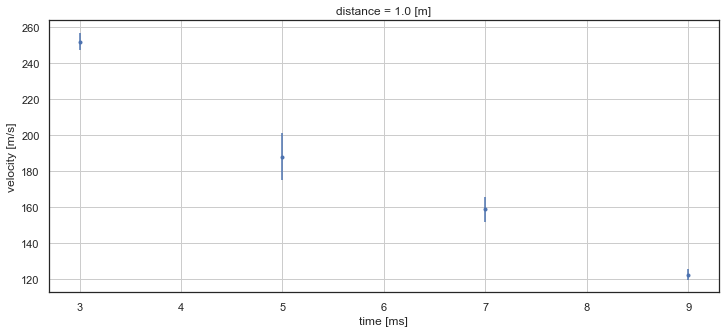

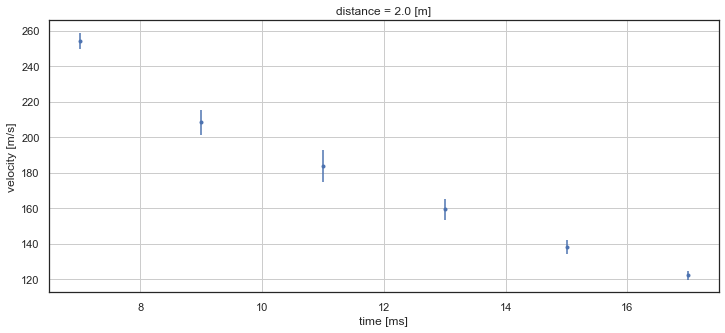

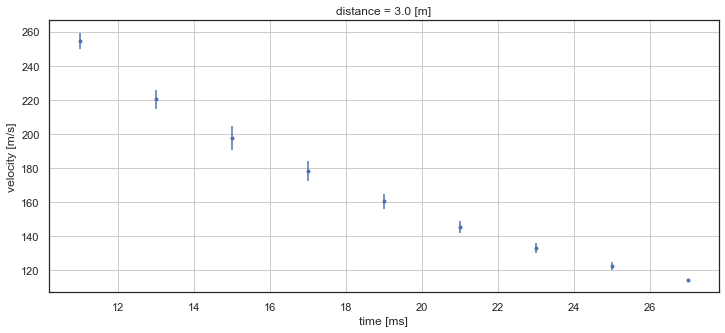

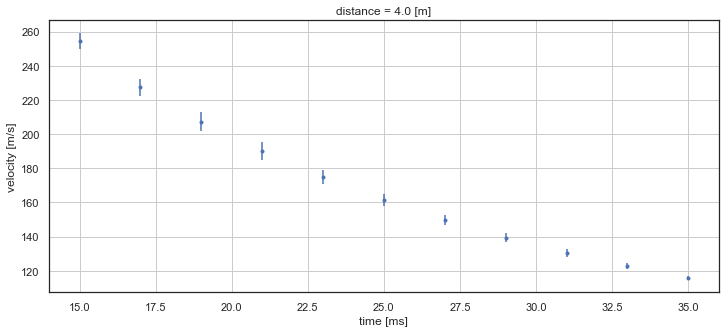

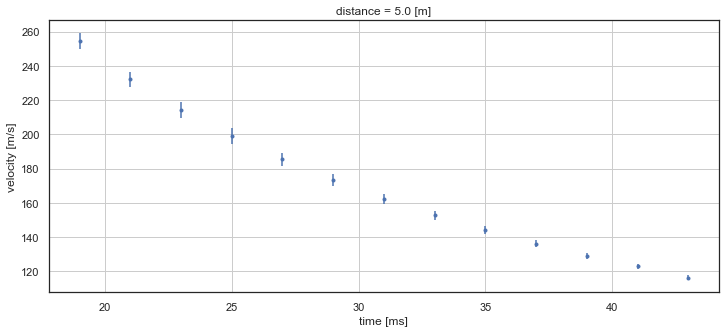

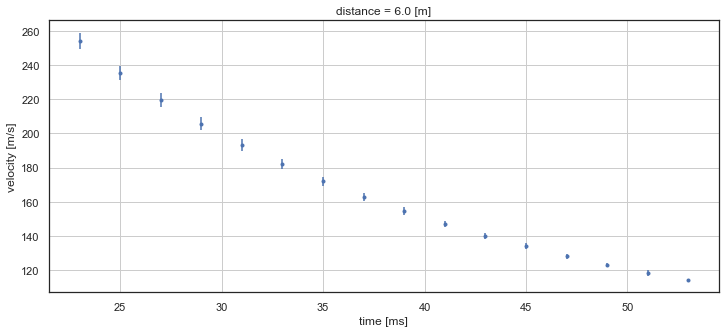

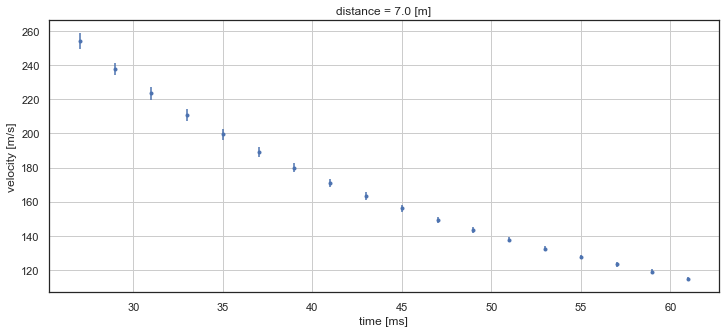

In [146]:
bin_width = 2e-3
bins_per_distance = []
vels_per_distance = []
for distance in distances:
    dat = df[distance]
    bins = np.arange(
        np.floor(dat.time.min()/bin_width), 
        np.ceil(dat.time.max()/bin_width)+0.5, 
        1
    ) * bin_width
    bins_per_distance.append(bins)
    m, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.mean, bins = bins)
    )
    std, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.std, bins = bins)
    )
    vels_per_distance.append(pd.DataFrame({'velocity': dat.velocity, 'bin': bin_number}))
    bins = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    bins *= 1e3
    fig, ax = plt.subplots(figsize = (12,5))
    ax.errorbar(bins, m, yerr = std, fmt = '.')
    ax.set_xlabel("time [ms]")
    ax.set_ylabel("velocity [m/s]")
    ax.set_title(f"distance = {distance:>3.1f} [m]")
    ax.grid(True)

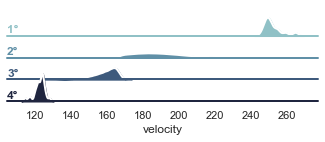

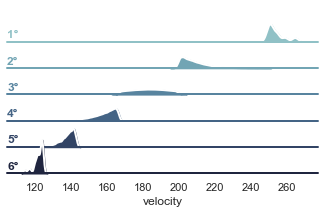

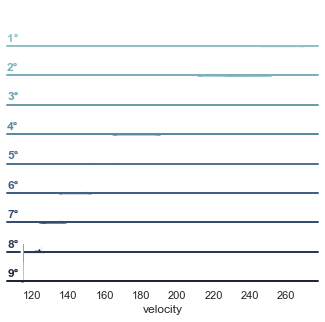

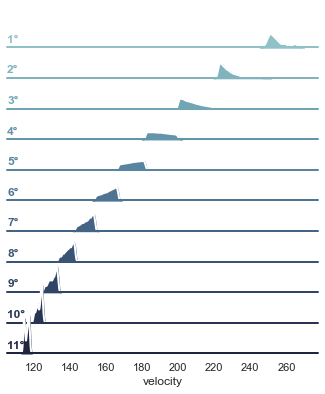

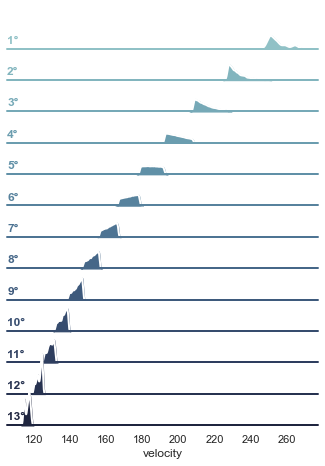

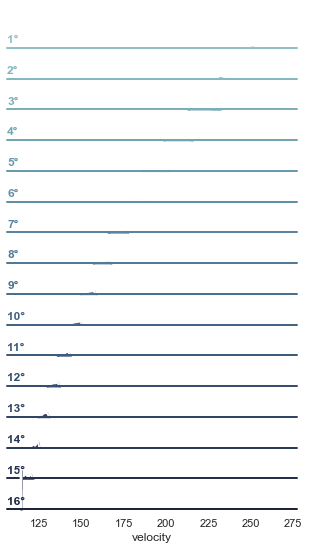

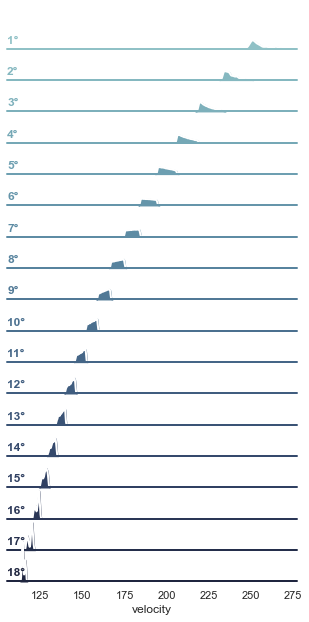

In [147]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for vel in vels_per_distance:
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(np.unique(vel.bin).size, rot=-.25, light=.7)
        g = sns.FacetGrid(vel, row="bin", hue="bin", aspect=10, height=0.5, palette=pal)

        # Draw the densities in a few steps
        g.map(sns.kdeplot, "velocity",
              bw_adjust=.5, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, "velocity", clip_on=False, color="w", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label}°", fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, "velocity")

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True);

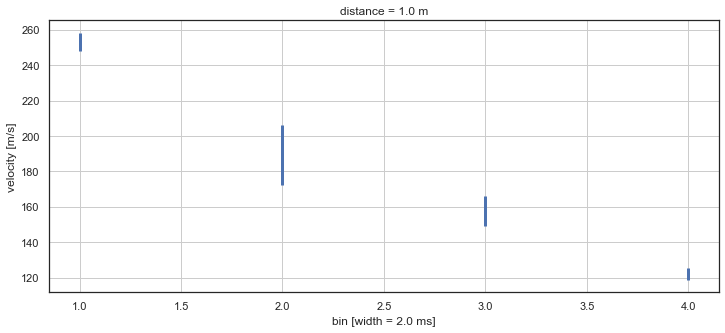

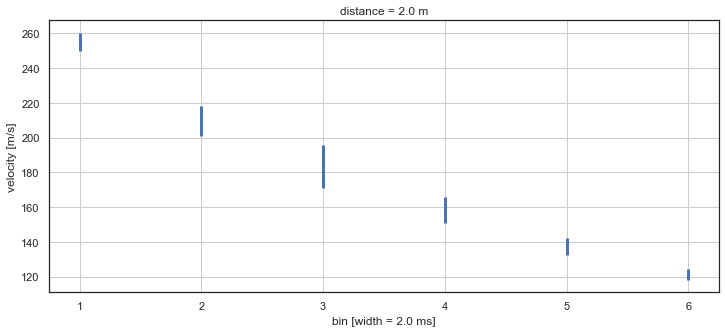

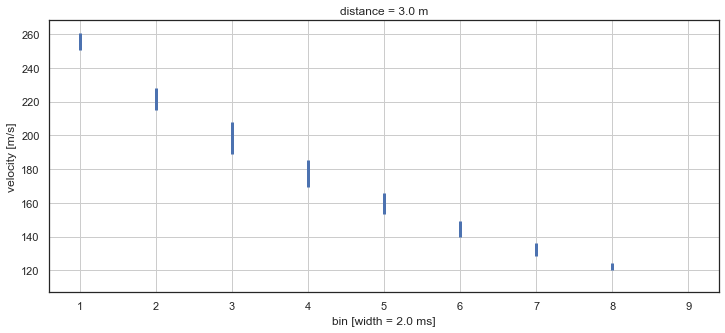

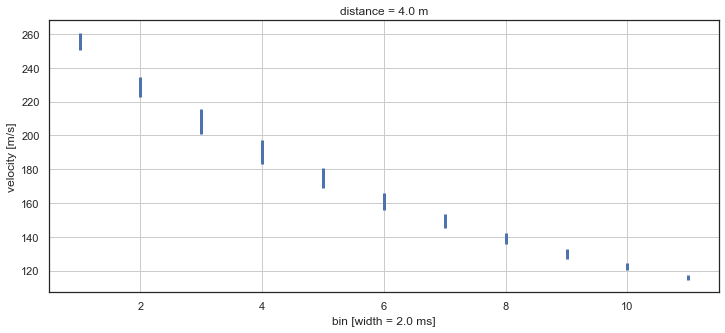

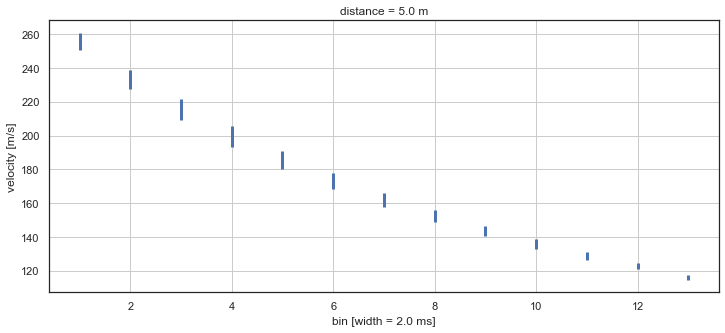

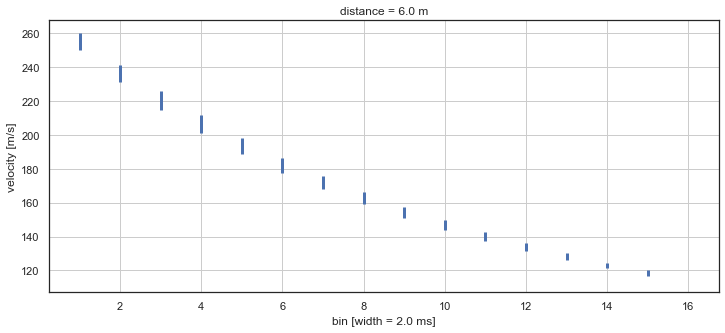

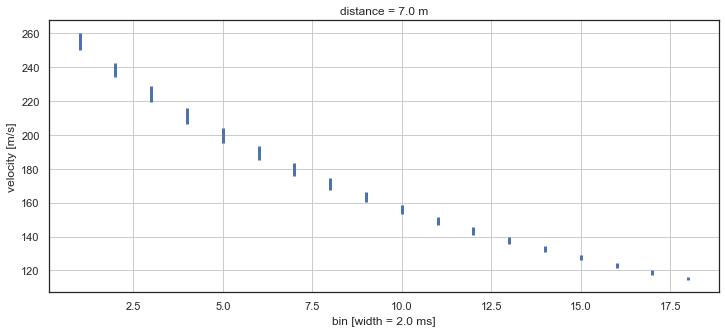

In [148]:
for d, vel in zip(distances, vels_per_distance):
    gb = vel.groupby('bin').describe(percentiles = [.1, .5, .9])['velocity']
    
    fig, ax = plt.subplots(figsize = (12,5))
    for ind in gb.index:
        ax.vlines(ind, ymin = gb.loc[ind]['10%'], ymax = gb.loc[ind]['90%'], lw = 3)
    ax.set_ylabel('velocity [m/s]')
    ax.set_xlabel(f'bin [width = {bin_width*1e3:.1f} ms]')
    ax.set_title(f'distance = {d:.1f} m')
    ax.grid(True)

In [149]:
for d, vel in zip(distances, vels_per_distance):
    gb = vel.groupby('bin').describe(percentiles = [.1, .5, .9])['velocity']
    print("=="*25)
    print(f"distance = {d:.1f}")
    for mi, ma in zip(gb['min'], gb['max']):
        print(f"min = {mi:.1f}, max = {ma:.1f}, ptp = {ma-mi:>5.1f}")

distance = 1.0
min = 246.5, max = 264.7, ptp =  18.3
min = 161.2, max = 251.0, ptp =  89.8
min = 123.7, max = 172.4, ptp =  48.7
min = 114.4, max = 128.3, ptp =  14.0
distance = 2.0
min = 249.8, max = 264.7, ptp =  15.0
min = 196.4, max = 250.3, ptp =  53.9
min = 163.9, max = 203.3, ptp =  39.4
min = 141.1, max = 169.5, ptp =  28.4
min = 124.3, max = 144.2, ptp =  20.0
min = 114.4, max = 125.3, ptp =  10.9
distance = 3.0
min = 250.1, max = 264.7, ptp =  14.6
min = 212.3, max = 250.3, ptp =  38.0
min = 185.5, max = 216.2, ptp =  30.7
min = 164.9, max = 189.7, ptp =  24.8
min = 148.9, max = 168.5, ptp =  19.6
min = 135.6, max = 151.6, ptp =  16.0
min = 125.0, max = 137.2, ptp =  12.2
min = 116.1, max = 125.3, ptp =   9.1
min = 114.4, max = 114.6, ptp =   0.3
distance = 4.0
min = 250.1, max = 264.7, ptp =  14.6
min = 220.9, max = 250.3, ptp =  29.4
min = 198.3, max = 223.5, ptp =  25.1
min = 180.4, max = 201.5, ptp =  21.2
min = 165.1, max = 183.3, ptp =  18.1
min = 152.8, max = 168.0, pt

# Gaussian Source Random Velocities Timed Pulse

In [90]:
v_origin = np.random.randn(n_trajectories)*vzσ + vz
t_origin = np.random.randn(n_trajectories)*pulse_width_absorption

In [91]:
distances = np.arange(1, 7.1, 1)

df = pd.DataFrame(columns = pd.MultiIndex.from_product([distances, ['time', 'velocity']]))

for distance in distances:
    t = distance / v_origin + t_origin
    df[distance] = pd.DataFrame({'time': t, 'velocity': v_origin})

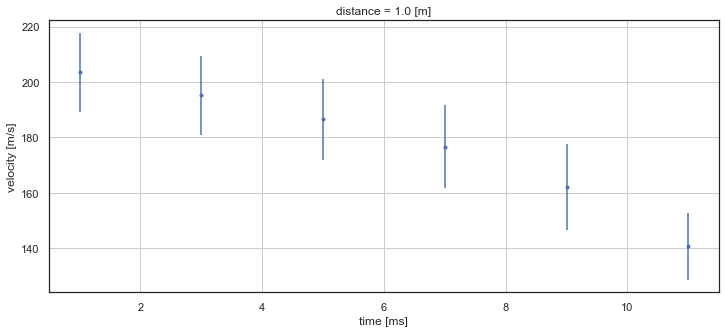

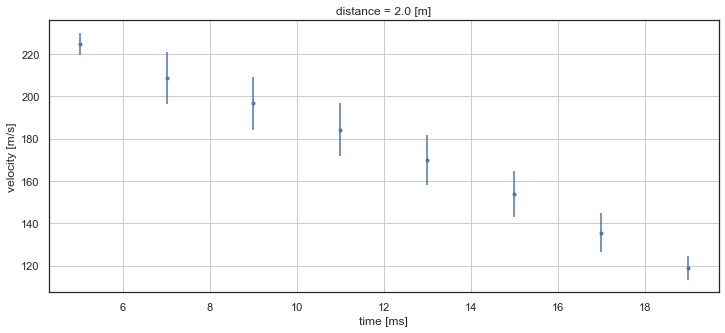

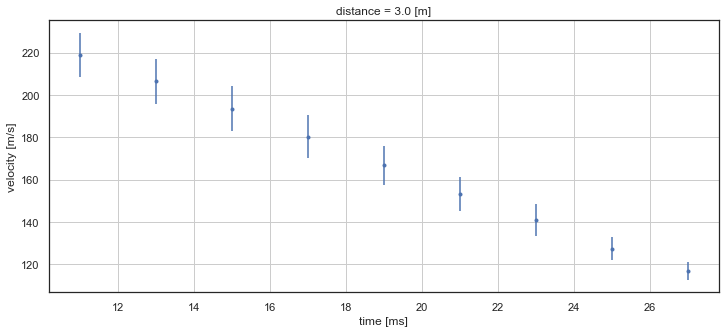

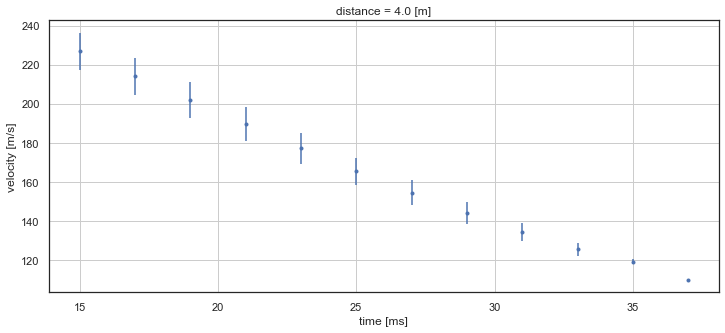

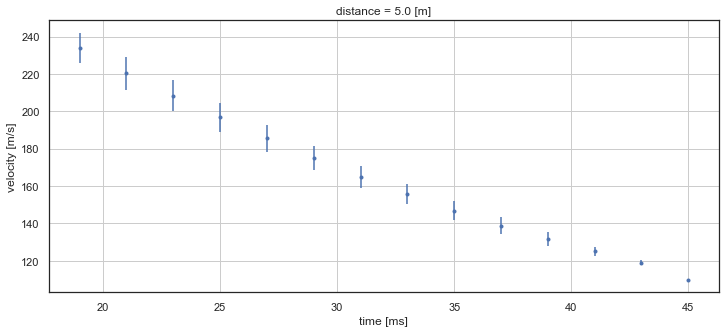

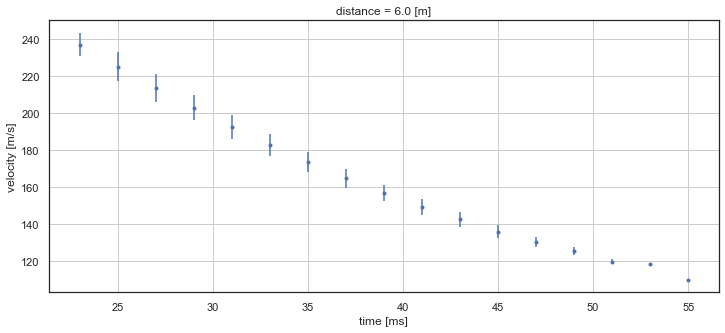

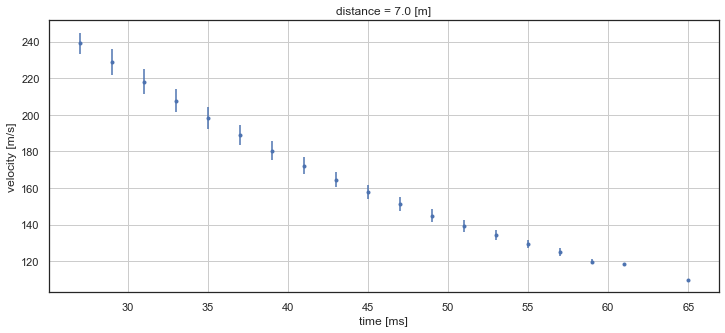

In [100]:
bin_width = 2e-3
bins_per_distance = []
vels_per_distance = []
for distance in distances:
    dat = df[distance]
    bins = np.arange(
        np.floor(dat.time.min()/bin_width), 
        np.ceil(dat.time.max()/bin_width)+0.5, 
        1
    ) * bin_width
    bins_per_distance.append(bins)
    m, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.mean, bins = bins)
    )
    std, bin_edges, bin_number = (
        stats.binned_statistic(dat.time, dat.velocity, statistic = np.std, bins = bins)
    )
    vels_per_distance.append(pd.DataFrame({'velocity': dat.velocity, 'bin': bin_number}))
    bins = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    bins *= 1e3
    fig, ax = plt.subplots(figsize = (12,5))
    ax.errorbar(bins, m, yerr = std, fmt = '.')
    ax.set_xlabel("time [ms]")
    ax.set_ylabel("velocity [m/s]")
    ax.set_title(f"distance = {distance:>3.1f} [m]")
    ax.grid(True)

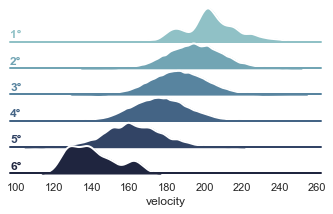

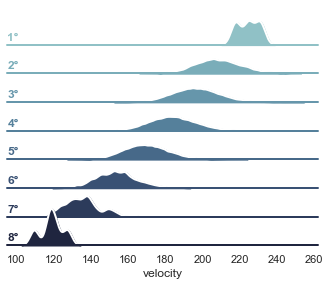

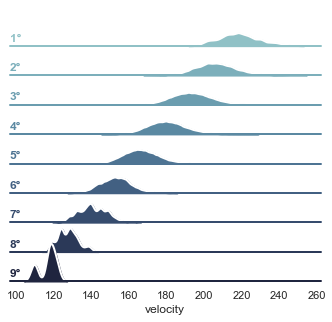

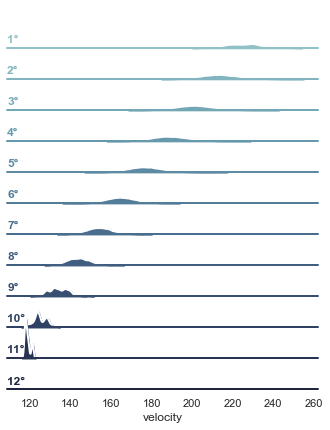

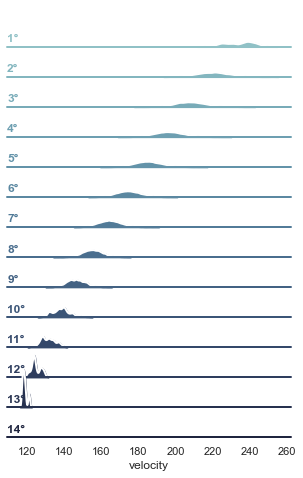

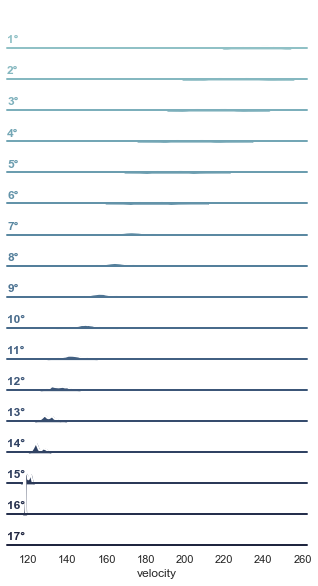

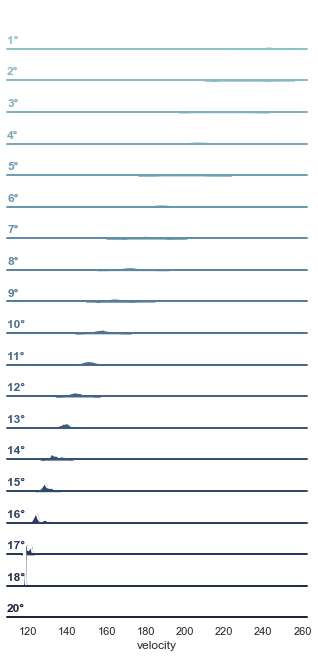

In [102]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for vel in vels_per_distance:
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(np.unique(vel.bin).size, rot=-.25, light=.7)
        g = sns.FacetGrid(vel, row="bin", hue="bin", aspect=10, height=0.5, palette=pal)

        # Draw the densities in a few steps
        g.map(sns.kdeplot, "velocity",
              bw_adjust=.5, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, "velocity", clip_on=False, color="w", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, f"{label}°", fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, "velocity")

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True);

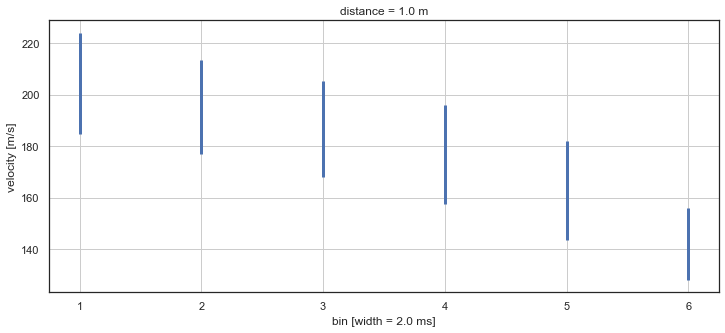

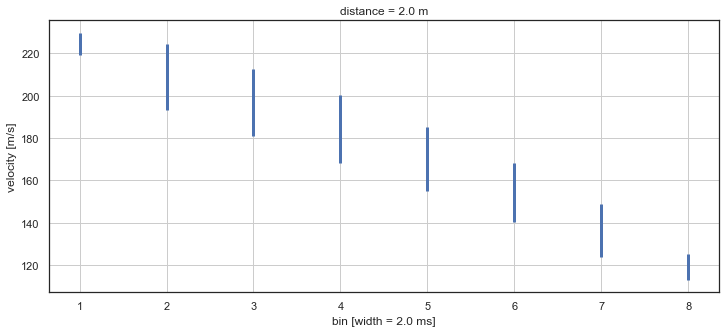

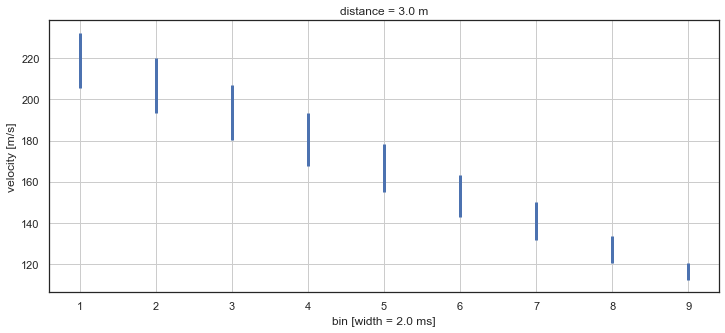

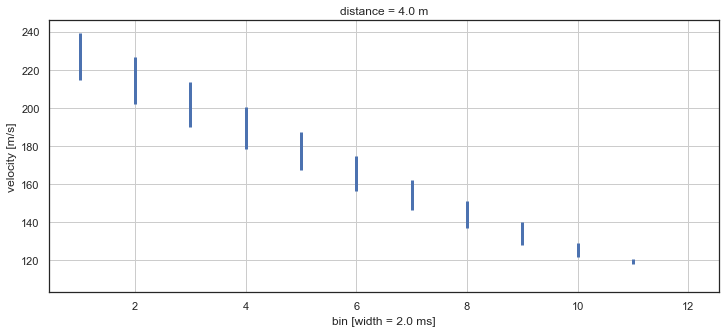

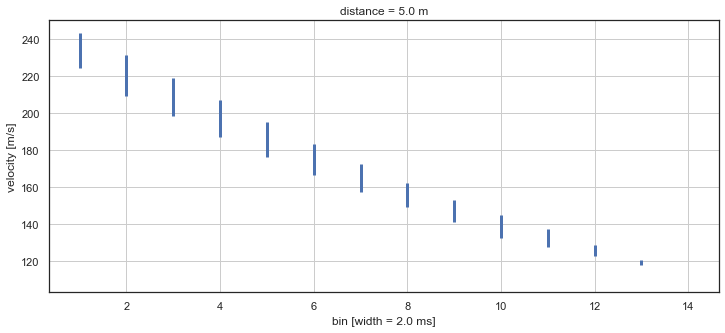

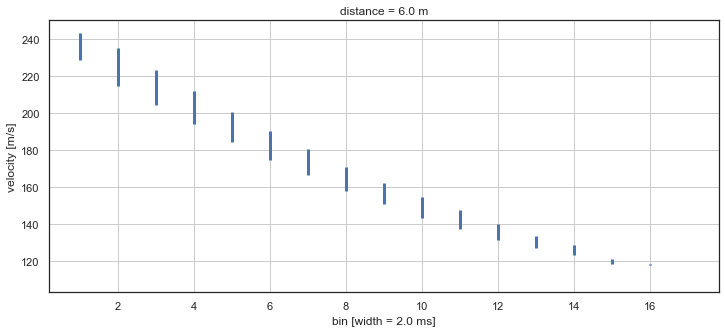

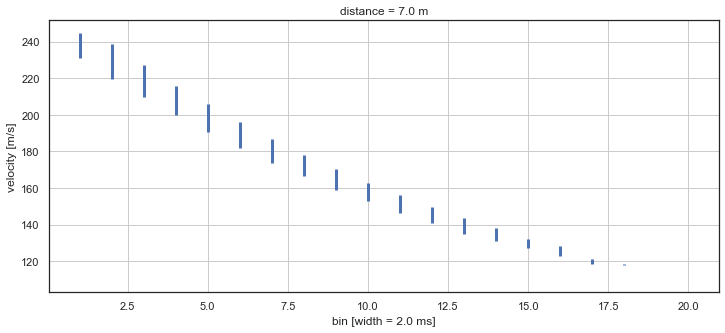

In [101]:
for d, vel in zip(distances, vels_per_distance):
    gb = vel.groupby('bin').describe(percentiles = [.1, .5, .9])['velocity']
    
    fig, ax = plt.subplots(figsize = (12,5))
    for ind in gb.index:
        ax.vlines(ind, ymin = gb.loc[ind]['10%'], ymax = gb.loc[ind]['90%'], lw = 3)
    ax.set_ylabel('velocity [m/s]')
    ax.set_xlabel(f'bin [width = {bin_width*1e3:.1f} ms]')
    ax.set_title(f'distance = {d:.1f} m')
    ax.grid(True)

In [108]:
for d, vel in zip(distances, vels_per_distance):
    gb = vel.groupby('bin').describe(percentiles = [.1, .5, .9])['velocity']
    print("=="*25)
    print(f"distance = {d:.1f}")
    for mi, ma in zip(gb['min'], gb['max']):
        print(f"min = {mi:.1f}, max = {ma:.1f}, ptp = {ma-mi:>5.1f}")

distance = 1.0
min = 170.5, max = 240.1, ptp =  69.7
min = 137.7, max = 248.3, ptp = 110.6
min = 131.4, max = 252.0, ptp = 120.6
min = 122.9, max = 232.9, ptp = 110.0
min = 109.8, max = 215.9, ptp = 106.2
min = 127.5, max = 162.7, ptp =  35.2
distance = 2.0
min = 217.9, max = 231.0, ptp =  13.1
min = 170.5, max = 248.3, ptp =  77.9
min = 154.9, max = 252.0, ptp =  97.1
min = 135.7, max = 236.0, ptp = 100.3
min = 129.7, max = 221.6, ptp =  91.9
min = 122.9, max = 189.9, ptp =  67.0
min = 117.8, max = 162.7, ptp =  44.8
min = 109.8, max = 127.5, ptp =  17.7
distance = 3.0
min = 196.8, max = 248.3, ptp =  51.6
min = 170.5, max = 252.0, ptp =  81.6
min = 156.4, max = 236.0, ptp =  79.6
min = 147.0, max = 227.2, ptp =  80.3
min = 135.7, max = 205.2, ptp =  69.5
min = 129.7, max = 183.3, ptp =  53.6
min = 122.9, max = 162.7, ptp =  39.8
min = 117.8, max = 139.4, ptp =  21.6
min = 109.8, max = 121.4, ptp =  11.6
distance = 4.0
min = 206.0, max = 248.3, ptp =  42.3
min = 187.7, max = 252.0, pt